# QC Panels — Tallinn (Local Time)


This notebook rebuilds the best-working version:


- Quick Elering API health check (last 6h UTC)

- Robust consolidation of our forecast snapshots

- Fetch actuals from Elering including today

- Hybrid plan provider (past from files, today/future from CSV with fallback)

- 3×3 daily line panel (last 7 days + tomorrow), unified Y-scale

- Daily metrics table and APE% sparklines

- Static HTML export to `scripts/plots/dashboard_details.html` and `docs/dashboard_details.html`

In [496]:
# === Quick Elering API health check (last 6h UTC) ===
import requests, pandas as pd
from datetime import datetime, timezone
BASE_URL = "https://dashboard.elering.ee/api/system/with-plan"
now_utc = datetime.now(timezone.utc)
start_utc = (pd.Timestamp(now_utc) - pd.Timedelta(hours=6)).to_pydatetime()
params = {
    "start": start_utc.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
    "end": now_utc.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
}
print("Calling:", BASE_URL)
print("Params:", params)
try:
    r = requests.get(BASE_URL, params=params, timeout=60)
    print("HTTP:", r.status_code)
    js = r.json()
    # Extract timestamp/consumption pairs
    rows = []
    def visit(node):
        if isinstance(node, dict):
            if "timestamp" in node and "consumption" in node:
                rows.append((node["timestamp"], node["consumption"]))
            for v in node.values():
                visit(v)
        elif isinstance(node, list):
            for it in node:
                visit(it)
    visit(js)
    print("Pairs found:", len(rows))
    if rows:
        ts0 = pd.to_datetime(rows[0][0], utc=True, errors="coerce")
        tsN = pd.to_datetime(rows[-1][0], utc=True, errors="coerce")
        print("Time range UTC:", ts0, "→", tsN)
    else:
        print("No consumption pairs in response. Possible causes: weekend/lag, API structure change, or window too narrow.")
        print("Tip: our downloader often excludes today by default; to include current hours, set exclude_today=False.")
except Exception as e:
    print("Request failed:", e)

Calling: https://dashboard.elering.ee/api/system/with-plan
Params: {'start': '2025-10-02T05:43:21.000Z', 'end': '2025-10-02T11:43:21.000Z'}
HTTP: 200
Pairs found: 45
Time range UTC: 1970-01-01 00:00:01.759383900+00:00 → 1970-01-01 00:00:01.759404600+00:00
HTTP: 200
Pairs found: 45
Time range UTC: 1970-01-01 00:00:01.759383900+00:00 → 1970-01-01 00:00:01.759404600+00:00


## QC Panels — Our vs Actual vs Plan (Europe/Tallinn)

This notebook draws 3×3 daily panels (local time Europe/Tallinn, 00–23) and a separate last-day dispersion:

- Actual vs Our (+ Plan snapshot, if available)
- Snapshot logic: for each day, use the freshest Elering plan CSV saved before that day
- Filters: workdays / weekends / all
- Outputs are saved to `scripts/plots` folder

Requirements in the project:
- `scripts/forecast_vs_actual_comparison_hourly.csv` (or `_enriched.csv`) – our forecast + actual (and ideally plan)
- `scripts/elering_forecast_from_YYYYMMDD.csv` – Elering plan snapshots

In [497]:
# --- Build or adopt comparison (cmp) and inject Elering plan/actual from WP_DF before saving ---
# Pylance-friendly: guard globals and avoid referencing undefined names directly
import pandas as pd
from pathlib import Path

# Guards for globals used in this cell
WP_DF = globals().get('WP_DF', pd.DataFrame())
raw_df = globals().get('raw_df', pd.DataFrame())
all_forecasts = globals().get('all_forecasts', pd.DataFrame())
_df_loaded = globals().get('df', pd.DataFrame())
_cmp_existing = globals().get('cmp', None)

QC_DIR = globals().get('QC_DIR', Path('scripts') / 'output' / 'qc')
QC_DIR.mkdir(parents=True, exist_ok=True)

# 1) Ensure we have a comparison DataFrame 'cmp'
if not isinstance(_cmp_existing, pd.DataFrame) or _cmp_existing.empty:
    if isinstance(_df_loaded, pd.DataFrame) and not _df_loaded.empty:
        # Adopt from loaded comparison CSV
        tmp = _df_loaded.copy()
        # normalize datetime
        if 'datetime_hour' not in tmp.columns and 'Ajatempel (UTC)' in tmp.columns:
            ts = pd.to_numeric(tmp['Ajatempel (UTC)'], errors='coerce')
            tmp['datetime_hour'] = pd.to_datetime(ts, unit='s', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
        else:
            tmp['datetime_hour'] = pd.to_datetime(tmp['datetime_hour'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
        # unify columns
        our = tmp.get('consumption_hourly', tmp.get('our'))
        act = tmp.get('Tarbimine', tmp.get('consumption'))
        plan = tmp.get('plan', tmp.get('elering_forecast'))
        cols = {
            'datetime_hour': tmp['datetime_hour'],
            'our': pd.to_numeric(our, errors='coerce') if our is not None else pd.NA,
            'consumption': pd.to_numeric(act, errors='coerce') if act is not None else pd.NA,
            'plan': pd.to_numeric(plan, errors='coerce') if plan is not None else pd.NA,
        }
        # keep some optional metadata if present
        if 'our_src_date' in tmp.columns:
            cols['our_day'] = tmp['our_src_date']
        if 'weekday' in tmp.columns:
            cols['weekday'] = tmp['weekday']
        if 'our_src_path' in tmp.columns:
            cols['src'] = tmp['our_src_path']
        cmp = pd.DataFrame(cols).dropna(subset=['datetime_hour']).sort_values('datetime_hour').reset_index(drop=True)
        print("cmp adopted from loaded df (CSV). Rows:", len(cmp))
    elif isinstance(all_forecasts, pd.DataFrame) and isinstance(raw_df, pd.DataFrame) and not all_forecasts.empty:
        # Fallback: build fresh from snapshots + actuals
        af = all_forecasts.copy()
        idx = af.groupby('datetime_hour')['age_sec'].idxmin()
        fdf = (
            af.loc[idx, ['datetime_hour','our','h_start','_src']]
              .sort_values('datetime_hour')
              .rename(columns={'h_start':'our_src_datetime','_src':'our_src_path'})
        )
        fdf['our_day'] = pd.to_datetime(fdf['our_src_datetime']).dt.date
        act = raw_df.rename(columns={'datetime_hour_utc':'datetime_hour'})[['datetime_hour','consumption']] if 'datetime_hour_utc' in raw_df.columns else raw_df[['datetime_hour','consumption']]
        cmp = pd.merge(fdf, act, on='datetime_hour', how='left').sort_values('datetime_hour')
        cmp['plan'] = pd.NA
        print("cmp built from snapshots + actuals. Rows:", len(cmp))
    else:
        raise RuntimeError("Missing 'cmp' and cannot derive from 'df' or (all_forecasts+raw_df). Load comparison first or run consolidation.")
else:
    cmp = _cmp_existing

# 2) Inject Elering plan + actual from WP_DF into comparison before saving
if isinstance(WP_DF, pd.DataFrame) and not WP_DF.empty:
    wp = WP_DF.copy()
    # Ühtlusta ajatempel: tunnini, UTC-naive (nagu cmp['datetime_hour'])
    ts = pd.to_datetime(wp['datetime_hour'], errors='coerce')
    if getattr(getattr(ts, 'dt', None), 'tz', None) is None:
        ts = ts.dt.tz_localize('UTC')
    ts = ts.dt.tz_convert('UTC').dt.floor('h').dt.tz_localize(None)
    wp['datetime_hour'] = ts
    keep_cols = [c for c in ['consumptionPlan', 'consumption'] if c in wp.columns]
    wp = wp[['datetime_hour', *keep_cols]]
    # liida WP_DF peale ja täida puuduvad veerud
    cmp = cmp.merge(wp, on='datetime_hour', how='left', suffixes=('', '_wp'))
    if 'plan' not in cmp.columns:
        cmp['plan'] = pd.NA
    if 'consumption' not in cmp.columns:
        cmp['consumption'] = pd.NA
    # täida puuduvad väärtused WP_DF-ist
    if 'consumptionPlan' in cmp.columns:
        cmp['plan'] = pd.to_numeric(cmp['plan'], errors='coerce').combine_first(pd.to_numeric(cmp['consumptionPlan'], errors='coerce'))
    if 'consumption_wp' in cmp.columns:
        cmp['consumption'] = pd.to_numeric(cmp['consumption'], errors='coerce').combine_first(pd.to_numeric(cmp['consumption_wp'], errors='coerce'))
    # koristus
    drop_cols = [c for c in ['consumptionPlan', 'consumption_wp'] if c in cmp.columns]
    if drop_cols:
        cmp.drop(columns=drop_cols, inplace=True)
    print("Injected plan/actual from WP_DF. Rows:", len(cmp))
else:
    print("WP_DF missing or empty — skipping injection.")

# 3) SAVE: ainult tavaline CSV (paneel loeb seda) — keep legacy format/sep/enc for downstream
cmp_save = cmp.copy()
# Optional add Ajatempel (UTC) seconds for legacy consumers
cmp_save['Ajatempel (UTC)'] = (pd.to_datetime(cmp_save['datetime_hour'], utc=True, errors='coerce').astype('int64') // 10**9)
# Legacy column names used elsewhere in the notebook
rename_map = {}
if 'consumption' in cmp_save.columns:
    rename_map['consumption'] = 'Tarbimine'
if 'our' in cmp_save.columns:
    rename_map['our'] = 'consumption_hourly'
if 'plan' in cmp_save.columns:
    rename_map['plan'] = 'elering_forecast'
cmp_save = cmp_save.rename(columns=rename_map)
# Order columns sensibly if present
preferred = [
    'datetime_hour', 'Ajatempel (UTC)', 'Tarbimine', 'consumption_hourly', 'elering_forecast',
    'our_day', 'weekday', 'src'
]
cols_out = [c for c in preferred if c in cmp_save.columns]
if not cols_out:
    cols_out = list(cmp_save.columns)
out_basic = QC_DIR / 'forecast_vs_actual_comparison_hourly.csv'
cmp_save[cols_out].to_csv(out_basic, sep=';', index=False, encoding='utf-8')
print('Saved comparison:', out_basic)

# 4) enriched-osa on välja kommenteeritud
# out_enrich = QC_DIR / 'forecast_vs_actual_comparison_hourly_enriched.csv'
# cmp_enriched = cmp.copy()
# cmp_enriched.to_csv(out_enrich, sep=';', index=False, encoding='utf-8')
# print('Saved enriched comparison:', out_enrich)

Injected plan/actual from WP_DF. Rows: 336
Saved comparison: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\forecast_vs_actual_comparison_hourly.csv


In [498]:
# === Settings ===
DAY_FILTER = "all" # "workdays" | "weekends" | "all"
DAY_SCOPE = "past" # "past" | "future" — select last N past days or next N future days
REQUIRE_PLAN = False # if True: show only days that have a plan snapshot
REQUIRE_PLAN_MIN_HOURS = 24 # minimum hours required from plan (0..24). e.g. 12 allows half-day plan
N_DAYS = 7 # number of days in the panel
TZ = "Europe/Tallinn"
VERBOSE = True # if True: print detailed diagnostics
from pathlib import Path
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
# Robust SCRIPTS detection/fallback for both runtime and Pylance (assign unconditionally)
cwd = Path.cwd()
SCRIPTS = globals().get('SCRIPTS', cwd if cwd.name.lower() == "scripts" else (cwd / "scripts"))
# Output folders
PLOTS_DIR = SCRIPTS / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
# QC folder under scripts/output/qc (as confirmed)
QC_DIR = SCRIPTS / "output" / "qc"
QC_DIR.mkdir(parents=True, exist_ok=True)
print("Plots will be saved to:", PLOTS_DIR.resolve())
print("QC outputs will be saved to:", QC_DIR.resolve())
print(f"Settings: DAY_FILTER={DAY_FILTER}, DAY_SCOPE={DAY_SCOPE}, REQUIRE_PLAN={REQUIRE_PLAN}, REQUIRE_PLAN_MIN_HOURS={REQUIRE_PLAN_MIN_HOURS}, N_DAYS={N_DAYS}")

Plots will be saved to: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots
QC outputs will be saved to: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc
Settings: DAY_FILTER=all, DAY_SCOPE=past, REQUIRE_PLAN=False, REQUIRE_PLAN_MIN_HOURS=24, N_DAYS=7


In [518]:
# --- Consolidate ALL forecasts from snapshot CSVs into all_forecasts ---
# Scans scripts/output recursively for files like 'forecast_consumption_hourly_next7_tallinn_YYYYMMDD_YYYYMMDD.csv'
# Builds a DataFrame with columns: [datetime_hour (UTC), our, age_sec, h_start, _src]
from pathlib import Path
import pandas as pd, re
# Locate scripts and output folder without try/except (SCRIPTS is assigned earlier)
_SCRIPTS = globals().get('SCRIPTS')
if _SCRIPTS is None:
    cwd = Path.cwd()
    _SCRIPTS = cwd if cwd.name.lower() == 'scripts' else cwd / 'scripts'
_OUTPUT = _SCRIPTS / 'output'
patterns = [
    re.compile(r"forecast_consumption_hourly.*?(\d{8}).*?(\d{8}).csv$", re.IGNORECASE),
]
csv_files = list(_OUTPUT.rglob('*.csv')) if _OUTPUT.is_dir() else []
rows = []

def _try_read_csv(p: Path) -> pd.DataFrame | None:
    for sep in [';', ',']:
        try:
            return pd.read_csv(p, sep=sep, encoding='utf-8', low_memory=False)
        except Exception:
            try:
                return pd.read_csv(p, sep=sep, encoding='cp1257', low_memory=False)
            except Exception:
                continue
    return None

def _parse_dt(df: pd.DataFrame) -> pd.Series:
    # Try common variants to get UTC-aware hourly timestamps
    cands = []
    if 'datetime_hour' in df.columns:
        s = pd.to_datetime(df['datetime_hour'], utc=True, errors='coerce')
        cands.append(s)
    for col in ['Aeg', 'Ajatempel (UTC)', 'timestamp']:
        if col in df.columns:
            if col == 'Ajatempel (UTC)':
                s = pd.to_datetime(pd.to_numeric(df[col], errors='coerce'), unit='s', utc=True, errors='coerce')
            else:
                try_ms = pd.to_datetime(pd.to_numeric(df[col], errors='coerce'), unit='ms', utc=True, errors='coerce')
                try_s = pd.to_datetime(pd.to_numeric(df[col], errors='coerce'), unit='s', utc=True, errors='coerce')
                try_iso= pd.to_datetime(df[col], utc=True, errors='coerce')
                s = max([try_ms, try_s, try_iso], key=lambda x: int(x.notna().sum()))
            cands.append(s)
    if cands:
        s = max(cands, key=lambda x: int(x.notna().sum()))
        return s.dt.floor('h')
    return pd.Series(dtype='datetime64[ns, UTC]')

for p in csv_files:
    m = None
    for pat in patterns:
        m = pat.search(p.name)
        if m:
            break
    if not m:
        continue
    df = _try_read_csv(p)
    if df is None or df.empty:
        continue
    # datetime
    dt_utc = _parse_dt(df)
    if dt_utc is None or dt_utc.isna().all():
        continue
    # value column detection (our forecast)
    val_col = None
    for c in ['consumption_hourly', 'forecast', 'our', 'value', 'Forecast', 'consumption']:
        if c in df.columns:
            val_col = c; break
    if val_col is None:
        # try numeric-only columns as last resort
        num_cols = [c for c in df.columns if c not in ('datetime_hour','Aeg','Ajatempel (UTC)','timestamp')]
        for c in num_cols:
            if pd.api.types.is_numeric_dtype(df[c]):
                val_col = c; break
    if val_col is None:
        continue
    our_vals = pd.to_numeric(df[val_col], errors='coerce')
    # snapshot date from filename, else file mtime
    try:
        snap_date = pd.to_datetime(m.group(1), format='%Y%m%d')
    except Exception:
        snap_date = pd.to_datetime(pd.Timestamp(p.stat().st_mtime, unit='s').date())
    h_start = pd.Timestamp(snap_date.date()).tz_localize('UTC') # midnight UTC
    part = pd.DataFrame({
        'datetime_hour': pd.to_datetime(dt_utc).dt.tz_convert('UTC').dt.tz_localize(None),
        'our': our_vals,
    }).dropna(subset=['datetime_hour'])
    if part.empty:
        continue
    part['_src'] = str(p)
    part['h_start'] = pd.to_datetime(h_start).tz_convert('UTC').tz_localize(None)
    # age = how far the forecast creation is from the target hour (smaller is fresher)
    part['age_sec'] = (part['datetime_hour'] - part['h_start']).dt.total_seconds()
    rows.append(part)

if rows:
    all_forecasts = pd.concat(rows, ignore_index=True)
    # keep reasonable bounds
    all_forecasts = all_forecasts.dropna(subset=['our'])
    all_forecasts = all_forecasts.sort_values(['datetime_hour','age_sec'])
    print('all_forecasts built:', len(all_forecasts), 'rows from', len(rows), 'files')
else:
    print('No forecast snapshot CSVs found under', _OUTPUT)

No forecast snapshot CSVs found under c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output


In [500]:
# --- Fix SCRIPTS path if it accidentally became <repo>/scripts/scripts ---
from pathlib import Path
_s = Path(str(globals().get('SCRIPTS', Path.cwd())))
if _s.name.lower() == 'scripts' and _s.parent.name.lower() == 'scripts':
    SCRIPTS = _s.parent
    print('Adjusted SCRIPTS to:', SCRIPTS)

In [501]:
# === Fetch Elering actuals INCLUDING today -> build raw_df (UTC-naive, hourly) ===
import sys
from pathlib import Path
import pandas as pd

# Ensure we can import elering_consumption from the scripts folder
sys.path.insert(0, str(globals().get('SCRIPTS', Path.cwd() / 'scripts')))
try:
    from elering_consumption import get_hourly_consumption
except Exception as e:
    raise ImportError(f"Failed to import elering_consumption from {sys.path[0]}: {e}")

# Pull last 2 months and EXPLICITLY include up to 'now' today
now_loc = pd.Timestamp.now(tz=TZ)
hourly_raw = get_hourly_consumption(
    2,                               # months back (positional)
    end_exclusive_local=now_loc,      # ← include hours up to now
    tz=TZ,
    exclude_today=False,              # ← allow today
    add_weekday=False,
    add_holidays=False,
    impute_missing=True,
)

if hourly_raw.empty:
    print("Elering hourly dataset is empty — check network/API.")
else:
    # Round to exact hours in UTC and aggregate duplicate entries within the same hour
    dt_utc = hourly_raw['sum_cons_time'].dt.tz_convert('UTC')
    dt_utc_floor = dt_utc.dt.floor('h')
    vals = pd.to_numeric(hourly_raw['sum_el_hourly_value'], errors='coerce')
    agg = (
        pd.DataFrame({'datetime_hour_utc': dt_utc_floor.dt.tz_localize(None), 'consumption': vals})
          .dropna(subset=['datetime_hour_utc'])
          .groupby('datetime_hour_utc', as_index=False)
          .agg(consumption=('consumption', 'mean'))
          .sort_values('datetime_hour_utc')
    )
    raw_df = agg.copy()

    # DIAG: ensure last 48h coverage
    start_diag = pd.Timestamp.now(tz=TZ).floor('D') - pd.Timedelta(days=1)
    end_diag = start_diag + pd.Timedelta(days=2)
    s_loc = pd.to_datetime(raw_df['datetime_hour_utc'], utc=True).dt.tz_convert(TZ)
    mask = (s_loc >= start_diag) & (s_loc < end_diag)
    cov = s_loc[mask].dt.floor('D').value_counts().sort_index()
    print("raw_df (hourly) built (including today): rows=", len(raw_df),
          "range:", raw_df['datetime_hour_utc'].min(), '→', raw_df['datetime_hour_utc'].max())
    print("Coverage last 2 days (local, hours per day):")
    for d, n in cov.items():
        print(" ", d.strftime('%Y-%m-%d'), ":", int(n), "hours")

raw_df (hourly) built (including today): rows= 1464 range: 2025-08-02 12:00:00 → 2025-10-02 11:00:00
Coverage last 2 days (local, hours per day):
  2025-10-01 : 24 hours
  2025-10-02 : 15 hours


In [502]:
# === Fetch long-range consumption + plan via CSV endpoint and build WP_DF ===
from urllib.parse import urlencode
import pandas as pd
from datetime import timedelta

BASE_CSV = "https://dashboard.elering.ee/api/system/with-plan/csv"


def _best_datetime(candidate_series: list[pd.Series]) -> pd.Series:
    best = None
    best_score = (-1, -9999)
    for s in candidate_series:
        if s is None:
            continue
        try:
            years = s.dt.year
            non_na = int(s.notna().sum())
            plausible = int(((years >= 2000) & (years <= 2100)).sum())
            score = (plausible, non_na)
        except Exception:
            score = (0, int(s.notna().sum()))
        if score > best_score:
            best_score = score
            best = s
    return best if best is not None else candidate_series[0]


def _parse_timestamp_column(df: pd.DataFrame) -> pd.Series:
    ts_col = next((c for c in ["Ajatempel (UTC)", "timestamp", "Aeg"] if c in df.columns), None)
    if ts_col is None:
        return pd.Series(dtype="datetime64[ns, UTC]")
    col = df[ts_col]
    s_candidates = []
    try:
        as_num = pd.to_numeric(col, errors="coerce")
        s_ms = pd.to_datetime(as_num, unit="ms", utc=True, errors="coerce")
        s_s = pd.to_datetime(as_num, unit="s", utc=True, errors="coerce")
        s_candidates.extend([s_ms, s_s])
    except Exception:
        pass
    try:
        s_iso = pd.to_datetime(col, utc=True, errors="coerce")
        s_candidates.append(s_iso)
    except Exception:
        pass
    if not s_candidates:
        return pd.Series(dtype="datetime64[ns, UTC]")
    s = _best_datetime(s_candidates)
    return s.dt.floor("h")


def _normalize_columns(dfr: pd.DataFrame) -> pd.DataFrame:
    rename_map = {}
    if "Planeeritud tarbimine" in dfr.columns and "consumptionPlan" not in dfr.columns:
        rename_map["Planeeritud tarbimine"] = "consumptionPlan"
    if "Tarbimine" in dfr.columns and "consumption" not in dfr.columns:
        rename_map["Tarbimine"] = "consumption"
    if rename_map:
        dfr = dfr.rename(columns=rename_map)
    return dfr


def _fetch_with_plan_chunk(su: pd.Timestamp, eu: pd.Timestamp,
                           fields=("consumption", "consumptionPlan")) -> pd.DataFrame:
    url = BASE_CSV + "?" + urlencode([
        ("start", su.strftime("%Y-%m-%dT%H:00:00Z")),
        ("end",   eu.strftime("%Y-%m-%dT%H:00:00Z")),
        ("fields", ",".join(fields)),
    ])
    try:
        dfr = pd.read_csv(url, sep=";", encoding="utf-8", low_memory=False)
    except Exception:
        dfr = pd.read_csv(url, sep=";", encoding="cp1257", low_memory=False)
    if dfr is None or dfr.empty:
        return pd.DataFrame()
    dfr = _normalize_columns(dfr)
    dt_utc = _parse_timestamp_column(dfr)
    if dt_utc.isna().all():
        return pd.DataFrame()
    out = pd.DataFrame({
        "datetime_hour": dt_utc.dt.tz_convert("UTC").dt.tz_localize(None)
    })
    for src_col, std_col in (("consumption", "consumption"), ("consumptionPlan", "consumptionPlan")):
        if src_col in dfr.columns:
            out[std_col] = pd.to_numeric(
                dfr[src_col].astype(str).str.replace("\"", "").str.replace(" ", "").str.replace(",", "."),
                errors="coerce",
            )
    return out.dropna(subset=["datetime_hour"]).sort_values("datetime_hour")


def fetch_with_plan_csv_range(start_utc: pd.Timestamp, end_utc: pd.Timestamp,
                               fields=("consumption", "consumptionPlan")) -> pd.DataFrame:
    su = pd.to_datetime(start_utc, utc=True)
    eu = pd.to_datetime(end_utc, utc=True)
    if su.tzinfo is None: su = su.tz_localize("UTC")
    if eu.tzinfo is None: eu = eu.tz_localize("UTC")
    if eu <= su:
        raise ValueError("end_utc must be after start_utc")
    parts = []
    cur = su
    one_year = pd.Timedelta(days=365)
    while cur < eu:
        chunk_end = min(eu, cur + one_year)
        part = _fetch_with_plan_chunk(cur, chunk_end, fields=fields)
        if not part.empty:
            parts.append(part)
        cur = chunk_end
    if not parts:
        return pd.DataFrame()
    dfc = pd.concat(parts, ignore_index=True).drop_duplicates(subset=["datetime_hour"]).sort_values("datetime_hour")
    if "consumptionPlan" not in dfc.columns:
        dfc["consumptionPlan"] = pd.NA
    if "consumption" not in dfc.columns:
        dfc["consumption"] = pd.NA
    return dfc

# Build a deterministic date range from settings (avoid NaT)
try:
    now_loc = pd.Timestamp.now(tz=TZ)
except Exception:
    now_loc = pd.Timestamp.utcnow().tz_localize('UTC').tz_convert('Europe/Tallinn')
# last N_DAYS past + tomorrow
n_days = int(globals().get('N_DAYS', 7))
start_loc = now_loc.floor('D') - pd.Timedelta(days=n_days)
end_loc = now_loc.floor('D') + pd.Timedelta(days=1)  # up to tomorrow 23:00 local
start_utc = start_loc.tz_convert('UTC')
end_utc = (end_loc - pd.Timedelta(hours=1)).tz_convert('UTC')  # inclusive 23:00

WP_DF = fetch_with_plan_csv_range(start_utc, end_utc)
if WP_DF is None or WP_DF.empty:
    # last-resort: 30d fallback
    nowu = pd.Timestamp.utcnow().tz_localize('UTC')
    WP_DF = fetch_with_plan_csv_range(nowu - pd.Timedelta(days=30), nowu + pd.Timedelta(days=2))

if WP_DF is None or WP_DF.empty:
    print("with-plan CSV fetch returned empty for:", start_utc, "→", end_utc)
else:
    print("with-plan rows:", len(WP_DF), "range:", WP_DF["datetime_hour"].min(), "→", WP_DF["datetime_hour"].max())
    # Optional: enrich df only if it has datetime_hour
    if "df" in globals() and isinstance(df, pd.DataFrame) and not df.empty and 'datetime_hour' in df.columns:
        # ensure UTC-naive hourly
        df['datetime_hour'] = pd.to_datetime(df['datetime_hour'], errors='coerce', utc=True).dt.floor('h').dt.tz_convert('UTC').dt.tz_localize(None)
        if "plan" not in df.columns:
            df["plan"] = pd.NA
        right = WP_DF.loc[:, [c for c in ["datetime_hour", "consumptionPlan"] if c in WP_DF.columns]]
        if not right.empty:
            df = df.merge(right, on="datetime_hour", how="left", suffixes=("", "_wp"))
            if "consumptionPlan_wp" in df.columns:
                # Fill existing plan with consumptionPlan_wp values where plan is NA
                df["plan"] = df["plan"].combine_first(df["consumptionPlan_wp"])
        # Optionally add actual from CSV if missing
        if "Tarbimine" not in df.columns and "consumption" in WP_DF.columns:
            rightA = WP_DF.loc[:, [c for c in ["datetime_hour", "consumption"] if c in WP_DF.columns]]
            if not rightA.empty:
                df = df.merge(rightA, on="datetime_hour", how="left", suffixes=("", "_api"))
                if "consumption" in df.columns and "Tarbimine" not in df.columns:
                    df.rename(columns={"consumption": "Tarbimine"}, inplace=True)
        globals()["df"] = df
        print("df enriched with plan from with-plan CSV.")

with-plan rows: 192 range: 2025-09-24 21:00:00 → 2025-10-02 20:00:00


In [503]:
# === Hybrid plan provider: past from files, today/future from CSV (fallback to files) ===
from urllib.parse import urlencode
import pandas as pd, re
from pathlib import Path
# Guard SCRIPTS for Pylance
SCRIPTS = globals().get('SCRIPTS', Path.cwd() if Path.cwd().name.lower() == 'scripts' else Path.cwd() / 'scripts')
ELERING_PLAN_PATTERN = re.compile(r"elering_forecast_from_(\d{8}).csv$")
# File-based provider for past days

def _plan_from_files(day_local, tz='Europe/Tallinn', min_hours=0):
    SCRIPTS_local = SCRIPTS
    files = sorted(SCRIPTS_local.glob("elering_forecast_from**.csv"))
    if not files:
        return None
    rows=[]
    dloc = pd.to_datetime(day_local).floor('D')
    for f in files:
        m = ELERING_PLAN_PATTERN.search(f.name)
        if not m:
            continue
        snap = pd.to_datetime(m.group(1), format="%Y%m%d")
        rows.append((snap, f))
    if not rows:
        return None
    # latest snapshot date <= day_local
    eligible = [r for r in rows if r[0] <= dloc]
    if not eligible:
        return None
    snap, path = max(eligible, key=lambda t: t[0])
    try:
        df = pd.read_csv(path, sep=';', encoding='utf-8', low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep=';', encoding='cp1257', low_memory=False)
    ts_col = next((c for c in ["Ajatempel (UTC)","timestamp"] if c in df.columns), None)
    if ts_col is None:
        return None
    dt_utc = pd.to_datetime(pd.to_numeric(df[ts_col], errors='coerce'), unit='s', utc=True).dt.floor('h')
    plan_col = "Planeeritud tarbimine" if "Planeeritud tarbimine" in df.columns else ("plan" if "plan" in df.columns else None)
    if plan_col is None:
        return None
    plan = pd.to_numeric(df[plan_col].astype(str).str.replace('"','').str.replace(' ','').str.replace(',','.'), errors='coerce')
    dt_loc = dt_utc.dt.tz_convert(tz).dt.tz_localize(None)
    out = (pd.DataFrame({"hour_local": dt_loc.dt.hour, "plan_snapshot": plan})
             .dropna(subset=["plan_snapshot"])
             .groupby("hour_local", as_index=False)
             .agg(plan_snapshot=("plan_snapshot", "last"))
             .sort_values(by="hour_local"))
    if int(min_hours) and out["hour_local"].nunique() < int(min_hours):
        return None
    return out if not out.empty else None

# CSV API provider for today/future

def _plan_from_csv(day_local, tz='Europe/Tallinn', min_hours=0):
    d0 = pd.to_datetime(day_local)
    if d0.tzinfo is None:
        d0 = d0.tz_localize(tz)
    else:
        d0 = d0.tz_convert(tz)
    start_utc = d0.floor('D').tz_convert('UTC')
    end_utc = (d0.floor('D') + pd.Timedelta(days=1) - pd.Timedelta(hours=1)).tz_convert('UTC')
    url = "https://dashboard.elering.ee/api/system/with-plan/csv?" + urlencode([
        ("start", start_utc.strftime("%Y-%m-%dT%H:00:00Z")),
        ("end", end_utc.strftime("%Y-%m-%dT%H:00:00Z")),
        ("fields","consumptionPlan"),
    ])
    try:
        df = pd.read_csv(url, sep=';', encoding='utf-8', low_memory=False)
    except Exception:
        df = pd.read_csv(url, sep=';', encoding='cp1257', low_memory=False)
    ts_col = next((c for c in ["Ajatempel (UTC)","timestamp","Aeg"] if c in df.columns), None)
    if ts_col is None:
        return None
    cand = [
        pd.to_datetime(pd.to_numeric(df[ts_col], errors='coerce'), unit='ms', utc=True, errors='coerce'),
        pd.to_datetime(pd.to_numeric(df[ts_col], errors='coerce'), unit='s', utc=True, errors='coerce'),
        pd.to_datetime(df[ts_col], utc=True, errors='coerce'),
    ]
    dt_utc = max(cand, key=lambda s: int(s.notna().sum())).dt.floor('h')
    if dt_utc.isna().all():
        return None
    plan_col = "consumptionPlan" if "consumptionPlan" in df.columns else ("Planeeritud tarbimine" if "Planeeritud tarbimine" in df.columns else None)
    if plan_col is None:
        return None
    plan = pd.to_numeric(df[plan_col].astype(str).str.replace('"','').str.replace(' ','').str.replace(',','.'), errors='coerce')
    if getattr(getattr(dt_utc,'dt',None),'tz',None) is None:
        dt_utc = dt_utc.dt.tz_localize('UTC')
    dt_loc = dt_utc.dt.tz_convert(tz).dt.tz_localize(None)
    out = (pd.DataFrame({"hour_local": dt_loc.dt.hour, "plan_snapshot": plan})
             .dropna(subset=["plan_snapshot"])
             .groupby("hour_local", as_index=False)
             .agg(plan_snapshot=("plan_snapshot", "last"))
             .sort_values(by="hour_local"))
    if int(min_hours) and out["hour_local"].nunique() < int(min_hours):
        return None
    return out if not out.empty else None

# Hybrid selector

def plan_snapshot_for_local_day(day_local, tz='Europe/Tallinn', min_hours=0):
    day_local = pd.to_datetime(day_local).floor('D')
    today_loc = pd.Timestamp.now(tz=tz).tz_localize(None).floor('D')
    if day_local < today_loc:
        return _plan_from_files(day_local, tz, min_hours)
    ps = _plan_from_csv(day_local, tz, min_hours=0)
    if ps is None or (int(min_hours) and ps["hour_local"].nunique() < int(min_hours)):
        ps = _plan_from_files(day_local, tz, min_hours)
    return ps

In [504]:
# === Plan snapshot provider (prefer WP_DF; robust fallback to files/CSV) ===
import pandas as pd

# Reuse helpers defined earlier in the notebook: _plan_from_files, _plan_from_csv
# This function will:
#  - Past days: prefer file snapshots; fallback to WP_DF; then CSV API
#  - Today/future: prefer WP_DF; fallback to CSV API; then files
#  - Honor min_hours if provided

def plan_snapshot_for_local_day(day_local, tz=TZ, min_hours=0):
    day_local = pd.to_datetime(day_local).floor('D')
    today_loc = pd.Timestamp.now(tz=tz).tz_localize(None).floor('D')

    def _ok(ps: pd.DataFrame | None) -> bool:
        if ps is None or not isinstance(ps, pd.DataFrame) or ps.empty:
            return False
        if int(min_hours):
            return int(ps.get('hour_local', pd.Series(dtype=int)).nunique()) >= int(min_hours)
        return True

    # Helper: build from WP_DF for a single local day
    def _plan_from_WP_DF(day_local, tz=tz):
        if 'WP_DF' not in globals() or not isinstance(WP_DF, pd.DataFrame) or WP_DF.empty:
            return None
        s = WP_DF.copy()
        # Avoid Optional[Series]: use explicit fallback Series for type checkers
        dt_src = s['datetime_hour'] if 'datetime_hour' in s.columns else pd.Series(dtype='datetime64[ns]')
        dt = pd.to_datetime(dt_src, errors='coerce', utc=True)
        if getattr(getattr(dt, 'dt', None), 'tz', None) is None:
            dt = dt.dt.tz_localize('UTC')
        else:
            dt = dt.dt.tz_convert('UTC')
        dt_local = dt.dt.tz_convert(tz).dt.tz_localize(None)
        s['day_local'] = dt_local.dt.floor('D')
        s['hour_local'] = dt_local.dt.hour
        s = s[s['day_local'] == pd.to_datetime(day_local).floor('D')]
        col = 'consumptionPlan' if 'consumptionPlan' in s.columns else None
        if col is None or s.empty:
            return None
        out = (
            s[['hour_local', col]]
              .rename(columns={col: 'plan_snapshot'})
              .dropna(subset=['plan_snapshot'])
              .groupby('hour_local', as_index=False)['plan_snapshot'].last()
              .sort_values('hour_local')
        )
        return out if not out.empty else None

    # Past days: prefer files first (historical snapshots are usually stored)
    if day_local < today_loc:
        ps = _plan_from_files(day_local, tz, min_hours)
        if _ok(ps):
            return ps
        # fallback to WP_DF
        ps = _plan_from_WP_DF(day_local, tz)
        if _ok(ps):
            return ps
        # last resort: CSV API for that day
        ps = _plan_from_csv(day_local, tz, min_hours)
        return ps if _ok(ps) else None

    # Today or future: prefer WP_DF first (already fetched range)
    ps = _plan_from_WP_DF(day_local, tz)
    if _ok(ps):
        return ps
    # fallback to CSV API (live)
    ps = _plan_from_csv(day_local, tz, min_hours=0)
    if _ok(ps):
        return ps
    # final fallback to local files
    ps = _plan_from_files(day_local, tz, min_hours)
    return ps if _ok(ps) else None

In [520]:
# === Load comparison data robustly and outer-merge WP_DF to fill plan/actual gaps ===
from pathlib import Path
import pandas as pd

# Use SCRIPTS folder (assign deterministically for Pylance)
_cwd = Path.cwd()
SCRIPTS = globals().get('SCRIPTS', _cwd if _cwd.name.lower() == 'scripts' else _cwd / 'scripts')
QC_DIR = SCRIPTS / "output" / "qc"

comp_main_candidates = [
    QC_DIR/"forecast_vs_actual_comparison_hourly.csv",
    SCRIPTS/"forecast_vs_actual_comparison_hourly.csv",
]
comp_alt_candidates = [
    QC_DIR/"forecast_vs_actual_comparison_hourly_enriched.csv",
    SCRIPTS/"forecast_vs_actual_comparison_hourly_enriched.csv",
]
comp_main = next((p for p in comp_main_candidates if p.is_file()), None)
comp_alt = next((p for p in comp_alt_candidates if p.is_file()), None)

if comp_main and comp_main.is_file():
    df = pd.read_csv(comp_main, sep=';', encoding='utf-8', low_memory=False)
    print("Loaded:", comp_main)
elif comp_alt and comp_alt.is_file():
    df = pd.read_csv(comp_alt, sep=';', encoding='utf-8', low_memory=False)
    print("Loaded:", comp_alt)
else:
    print("Warning: Missing forecast_vs_actual_comparison_hourly(.csv|_enriched.csv) in QC or scripts folder")
    df = None

# If WP_DF exists, outer-merge in to add missing hours and plan/actual columns
if df is not None:
    # Normalize datetime_hour
    if 'datetime_hour' not in df.columns and 'Ajatempel (UTC)' in df.columns:
        ts = pd.to_numeric(df['Ajatempel (UTC)'], errors='coerce')
        df['datetime_hour'] = pd.to_datetime(ts, unit='s', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
    else:
        df['datetime_hour'] = pd.to_datetime(df['datetime_hour'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)

    # Build a WP slice for the same datetime range
    if 'WP_DF' in globals() and isinstance(WP_DF, pd.DataFrame) and not WP_DF.empty:
        wp = WP_DF.copy()
        wp['datetime_hour'] = pd.to_datetime(wp['datetime_hour'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
        right = wp[['datetime_hour'] + [c for c in ['consumption', 'consumptionPlan'] if c in wp.columns]].drop_duplicates('datetime_hour')
        # Outer join to ensure we don't drop hours that exist only in WP_DF (e.g., today)
        df = df.merge(right, on='datetime_hour', how='outer', suffixes=('', '_wp'))
        # Consolidate plan column: prefer existing 'plan' or 'elering_forecast', else use consumptionPlan
        if 'plan' not in df.columns:
            if 'elering_forecast' in df.columns:
                df['plan'] = pd.to_numeric(df['elering_forecast'], errors='coerce')
            elif 'consumptionPlan' in df.columns:
                df['plan'] = pd.to_numeric(df['consumptionPlan'], errors='coerce')
            else:
                df['plan'] = pd.NA
        else:
            # fill missing plan with consumptionPlan
            if 'consumptionPlan' in df.columns:
                df['plan'] = pd.to_numeric(df['plan'], errors='coerce').combine_first(pd.to_numeric(df['consumptionPlan'], errors='coerce'))
        # Consolidate actual column if missing or partially missing
        if 'Tarbimine' in df.columns:
            # fill NaNs from with-plan consumption
            if 'consumption' in df.columns:
                df['Tarbimine'] = pd.to_numeric(df['Tarbimine'], errors='coerce').combine_first(pd.to_numeric(df['consumption'], errors='coerce'))
            elif 'consumption_wp' in df.columns:
                df['Tarbimine'] = pd.to_numeric(df['Tarbimine'], errors='coerce').combine_first(pd.to_numeric(df['consumption_wp'], errors='coerce'))
        else:
            # try original 'consumption' in left; else right's consumption
            if 'consumption' in df.columns:
                df.rename(columns={'consumption': 'Tarbimine'}, inplace=True)
            elif 'consumption_wp' in df.columns:
                df.rename(columns={'consumption_wp': 'Tarbimine'}, inplace=True)

    # normalize duplicate elering_forecast_x/y if present
    if 'elering_forecast' not in df.columns and ('elering_forecast_x' in df.columns or 'elering_forecast_y' in df.columns):
        df['elering_forecast'] = df.get('elering_forecast_x')
        if 'elering_forecast_y' in df.columns:
            df['elering_forecast'] = df['elering_forecast'].combine_first(df['elering_forecast_y'])

    # Ensure a 'plan' column exists
    if 'plan' not in df.columns:
        if 'elering_forecast' in df.columns:
            df['plan'] = df['elering_forecast']
        elif 'consumptionPlan' in df.columns:
            df['plan'] = df['consumptionPlan']
        else:
            df['plan'] = pd.NA

    print("Columns:", list(df.columns)[:18], '...')
    print("Rows:", len(df))
else:
    print("No comparison DataFrame loaded (df is None).")

Loaded: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc\forecast_vs_actual_comparison_hourly.csv
Columns: ['datetime_hour', 'Ajatempel (UTC)', 'Tarbimine', 'consumption_hourly', 'elering_forecast', 'our_day', 'src', 'consumption', 'consumptionPlan', 'plan'] ...
Rows: 336


In [506]:
# === Helpers: convert to local time; base DataFrame ===
import pandas as pd

# Check if df is defined and is a DataFrame
if 'df' not in globals() or not isinstance(df, pd.DataFrame):
    raise NameError("The variable 'df' is not defined or is not a DataFrame. Please ensure the comparison data is loaded.")

# --- ühtlusta plaani veerg enne base loomist ---
# Tagab, et kasutame ühtset 'plan' veergu, ka siis kui on vaid 'elering_forecast'.
if 'plan' not in df.columns:
    if 'elering_forecast' in df.columns:
        df['plan'] = pd.to_numeric(df['elering_forecast'], errors='coerce')
    else:
        df['plan'] = pd.NA


def to_local(dt_series, tz=TZ):
    s = pd.to_datetime(dt_series, errors="coerce")
    if getattr(s.dt, "tz", None) is None:
        s = s.dt.tz_localize("UTC")
    s = s.dt.tz_convert(tz)
    return s.dt.tz_localize(None)

base = df.copy()
if "datetime_hour" not in base.columns:
    # try Ajatempel (UTC) -> seconds
    if 'Ajatempel (UTC)' in base.columns:
        ts = pd.to_numeric(base['Ajatempel (UTC)'], errors='coerce')
        base['datetime_hour'] = pd.to_datetime(ts, unit='s', utc=True)
    else:
        raise ValueError("Missing 'datetime_hour' or 'Ajatempel (UTC)'.")
base['dt_local'] = to_local(base['datetime_hour'])
base['day_local'] = base['dt_local'].dt.floor('D')
base['hour_local']= base['dt_local'].dt.hour
# --- vali väärtuste veerud (originaalnimed) ---
col_actual = 'Tarbimine' if 'Tarbimine' in base.columns else ('consumption' if 'consumption' in base.columns else None)
col_our = 'consumption_hourly' if 'consumption_hourly' in base.columns else None
# --- ühtlusta plaan enne base-t (df peal tehtud; kordame turvaliselt siin) ---
if 'plan' not in df.columns:
    if 'elering_forecast' in df.columns:
        df['plan'] = pd.to_numeric(df['elering_forecast'], errors='coerce')
    else:
        df['plan'] = pd.NA
# NB: kui tegid df->base koopia varem, uuenda base ka
if 'plan' not in base.columns and 'plan' in df.columns:
    base['plan'] = pd.to_numeric(df['plan'], errors='coerce')
# --- 1) RENAME enne valikut (vältimaks KeyError’it) ---
tmp = base.rename(columns={
    col_actual: 'actual',
    col_our: 'our',
    'plan': 'plan', # safe no-op
}, errors='ignore')
# Lisa puuduolevad meie standardveerud tühjana, et hilisemad groupby’d ei kukuks
for c in ['our', 'actual', 'plan']:
    if c not in tmp.columns:
        tmp[c] = pd.NA
# --- 2) Nüüd vali vaid olemasolevad ---
need = ['dt_local', 'day_local', 'hour_local', 'actual', 'our', 'plan']
extra = [c for c in ["our_src_label", "our_src_date"] if c in tmp.columns]
present = [c for c in (need + extra) if c in tmp.columns]
base = (tmp[present]
        .sort_values(['day_local','hour_local'])
        .copy())
# --- 3) Kui plan ikka puudub, lisa tühjana (NA), mitte ära kukuta ---
if 'plan' not in base.columns:
    base['plan'] = pd.NA

# === Day selection (full 24h of our forecast) + filters [kept for diagnostics] ===
# The panel’s fixed logic lives in the panel cell; this cell remains for diagnostics
if 'our' in base.columns:
    full_days_ours = base.groupby('day_local')['our'].apply(lambda x: pd.to_numeric(x, errors='coerce').notna().sum()==24)
else:
    full_days_ours = pd.Series(dtype=bool)
if 'actual' in base.columns:
    full_days_actual = base.groupby('day_local')['actual'].apply(lambda x: pd.to_numeric(x, errors='coerce').notna().sum()==24)
else:
    full_days_actual = pd.Series(dtype=bool)

diag = (
    pd.DataFrame({
        'our_24': full_days_ours,
        'actual_24': full_days_actual
    })
    .reset_index()
    .rename(columns={'index':'day_local'})
    .sort_values('day_local')
)
if VERBOSE:
    print("\n— Day quality (diagnostics) —")
    try:
        from IPython.display import display
        display(diag.tail(20))
    except Exception:
        print(diag.tail(20))
# Earlier filter logic isn't critical to the panel now
now_local = pd.Timestamp.now(tz=TZ).tz_localize(None)
today_local = now_local.floor('D')
print("Diagnostic today:", today_local.date())


— Day quality (diagnostics) —


,day_local,our_24,actual_24
0,2025-09-19,True,True
1,2025-09-20,True,True
2,2025-09-21,True,True
3,2025-09-22,True,True
4,2025-09-23,True,True
5,2025-09-24,True,True
6,2025-09-25,True,True
7,2025-09-26,True,True
8,2025-09-27,True,True
9,2025-09-28,True,True


Diagnostic today: 2025-10-02


Days shown in panel: ['2025-09-26', '2025-09-27', '2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02', '2025-10-03']


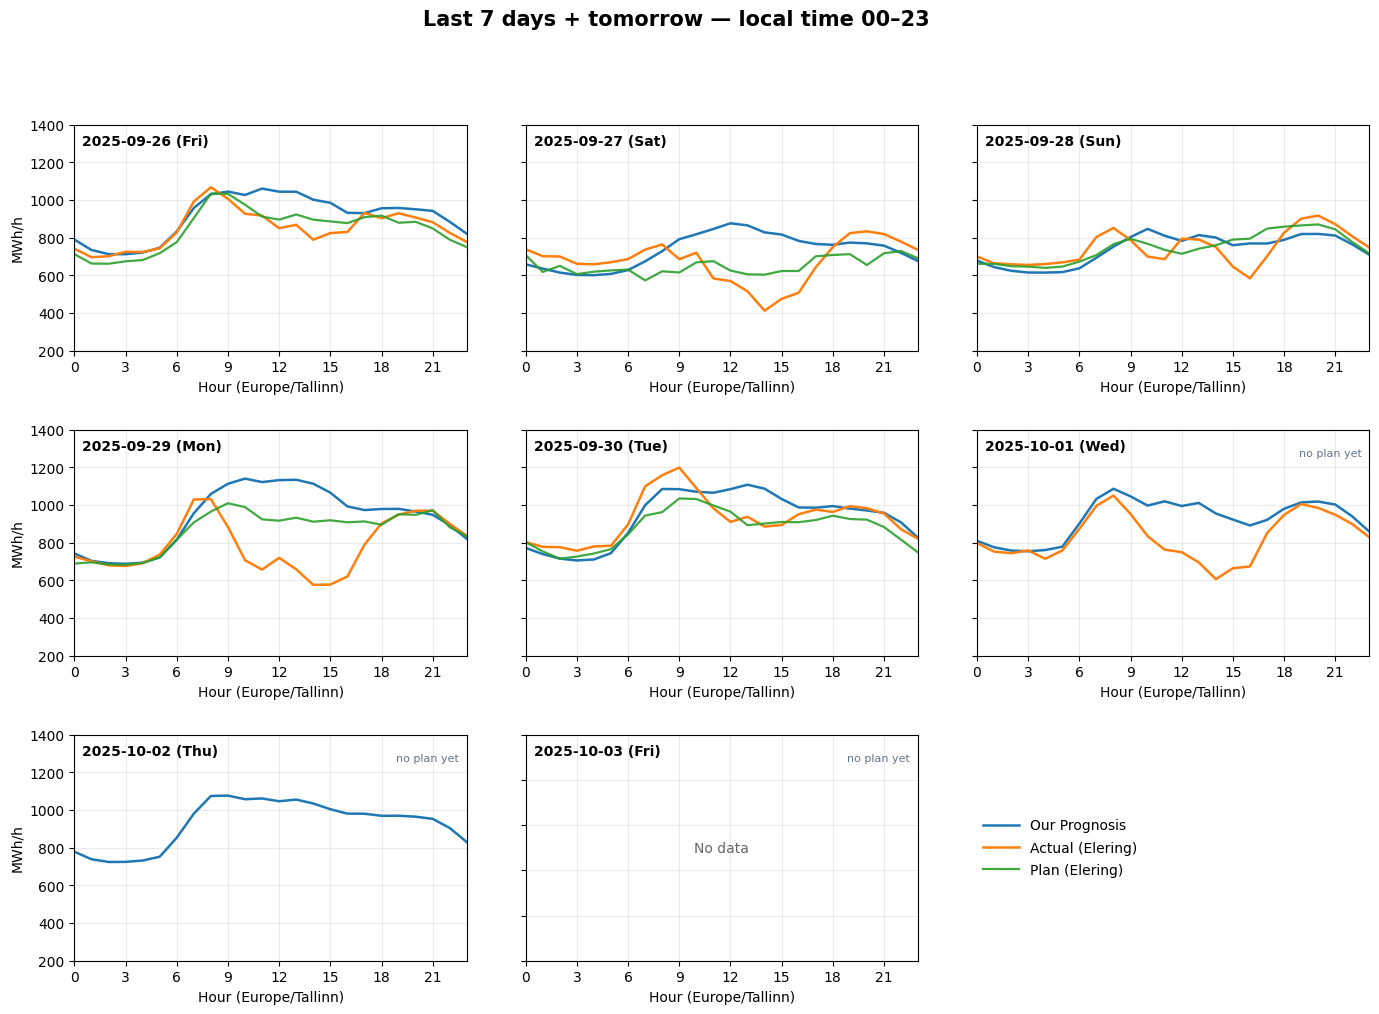

Saved: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\panel_local_all.png
Days in panel: ['2025-09-26', '2025-09-27', '2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02', '2025-10-03']
Diagnostic day: 2025-10-03
our N: 0
actual N: 0
plan_snapshot hour count: 0
days_all: ['2025-09-26', '2025-09-27', '2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02', '2025-10-03']


,day_local,our_hours,actual_hours,plan_snapshot_hours
0,2025-09-24,24,24,1
1,2025-09-25,24,24,24
2,2025-09-26,24,24,24
3,2025-09-27,24,24,24
4,2025-09-28,24,24,24
5,2025-09-29,24,24,24
6,2025-09-30,24,24,24
7,2025-10-01,24,24,1
8,2025-10-02,24,5,0
9,2025-10-03,0,0,0


In [507]:
# === 3×3 LINE PANEL — 9th cell = legend (vertical), unified Y-scale ===
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 11))
axes = axes.flatten()  # flatten to 1D array for easy indexing
# Determine which days to show in the panel
if globals().get('DAY_SCOPE', 'past') == 'past':
    past_days = [today_local - pd.Timedelta(days=i) for i in range(6, -1, -1)]
    days_all = past_days + [today_local + pd.Timedelta(days=1)]  # include tomorrow back
else:
    days_all = [today_local + pd.Timedelta(days=i) for i in range(0, 7)]
print('Days shown in panel:', [str(pd.to_datetime(d).date()) for d in days_all])
# Fixed colors and styles
COLORS = {
    'Our Prognosis': '#1f77b4', # blue
    'Actual (Elering)': '#ff7f0e', # orange
    'Plan (Elering)': '#2ca02c' # green
}
STYLES = {
    'Our Prognosis': {'linewidth': 1.8},
    'Actual (Elering)': {'linewidth': 1.8},
    'Plan (Elering)': {'linewidth': 1.6, 'alpha': 0.9}
}
legend_handles, legend_labels = [], []

def add_legend_item(h, label):
    if h is None:
        return
    if label not in legend_labels:
        legend_handles.append(h)
        legend_labels.append(label)

# --- Unified Y-scale for all subplots ---
y_min, y_max = float("inf"), float("-inf")

def _nice_step(span):
    candidates = [25, 50, 100, 200, 250, 500, 1000]
    for st in candidates:
        if span / st <= 8:
            return st
    return max(1000, span / 8.0)

for i, ax in enumerate(axes):
    if i >= len(days_all):
        ax.axis('off')
        continue
    d = pd.to_datetime(days_all[i]).floor('D')
    s = base[base['day_local'].dt.floor('D') == d].sort_values('hour_local')
    is_future = d > today_local
    has_any = False
    # OUR
    if 'our' in s.columns and s['our'].notna().any():
        yO = pd.to_numeric(s['our'], errors='coerce')
        if yO.notna().any():
            hO = ax.plot(s['hour_local'], yO, label='Our Prognosis', color=COLORS['Our Prognosis'], **STYLES['Our Prognosis'])[0]
            add_legend_item(hO, 'Our Prognosis'); has_any = True
            y_min = min(y_min, float(yO.min())); y_max = max(y_max, float(yO.max()))
    # ACTUAL — do not draw for future day
    if (not is_future) and 'actual' in s.columns and s['actual'].notna().any():
        yA = pd.to_numeric(s['actual'], errors='coerce')
        if yA.notna().any():
            hA = ax.plot(s['hour_local'], yA, label='Actual (Elering)', color=COLORS['Actual (Elering)'], **STYLES['Actual (Elering)'])[0]
            add_legend_item(hA, 'Actual (Elering)'); has_any = True
            y_min = min(y_min, float(yA.min())); y_max = max(y_max, float(yA.max()))
    # PLAN (hybrid provider) — require more coverage for past days to avoid 1-pt invisibility
    is_today = d == today_local
    base_min = int(REQUIRE_PLAN_MIN_HOURS) if REQUIRE_PLAN else 0
    if d < today_local:
        minh = max(base_min, 12)  # force fallback to daily CSV if WP_DF is sparse
    elif is_today:
        minh = 0 if not REQUIRE_PLAN else base_min
    else:
        minh = base_min
    ps = plan_snapshot_for_local_day(d, min_hours=minh)
    if ps is not None and len(ps):
        yP = pd.to_numeric(ps['plan_snapshot'], errors='coerce')
        if yP.notna().any():
            plot_kwargs = STYLES['Plan (Elering)'].copy()
            if len(ps) < 2:
                plot_kwargs.update({'marker': 'o', 'linestyle': 'None', 'markersize': 4}) # type: ignore
            hP = ax.plot(ps['hour_local'], yP, label='Plan (Elering)', color=COLORS['Plan (Elering)'], **plot_kwargs)[0]
            add_legend_item(hP, 'Plan (Elering)'); has_any = True
            y_min = min(y_min, float(yP.min())); y_max = max(y_max, float(yP.max()))
        else:
            ax.text(0.98, 0.92, 'no plan yet', transform=ax.transAxes, ha='right', va='top', fontsize=8, color='#64748b')
    else:
        ax.text(0.98, 0.92, 'no plan yet', transform=ax.transAxes, ha='right', va='top', fontsize=8, color='#64748b')
    # Title with weekday
    wdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    wd = wdays[d.weekday()]
    ax.text(0.02, 0.96, f"{d.date()} ({wd})", transform=ax.transAxes, ha='left', va='top', fontsize=10, fontweight='semibold')
    # Stamp forecast source date used for that day (if available)
    try:
        src_lbl = s['our_src_label'].dropna().iloc[0] if 'our_src_label' in s.columns and s['our_src_label'].notna().any() else None
    except Exception:
        src_lbl = None
    if src_lbl:
        ax.text(0.98, 0.04, f"src {src_lbl}", transform=ax.transAxes, ha='right', va='bottom', fontsize=8, color='#475569', alpha=0.95, bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='#cbd5e1', alpha=0.7))
    if not has_any:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, alpha=0.6)
    ax.set_xlim(0, 23); ax.set_xticks(range(0, 24, 3))
    ax.set_xlabel('Hour (Europe/Tallinn)'); ax.tick_params(axis='x', labelbottom=True)
    if i % cols == 0:
        ax.set_ylabel('MWh/h')
    else:
        ax.tick_params(axis='y', labelleft=False)
    ax.grid(True, alpha=0.25)
# Unified Y-scale
if np.isfinite(y_min) and np.isfinite(y_max) and y_min < y_max:
    pad = 20.0
    lo = max(0.0, np.floor((y_min - pad) / 25.0) * 25.0)
    hi = np.ceil((y_max + pad) / 25.0) * 25.0
    span = max(hi - lo, 1.0)
    step = _nice_step(span)
    lo = np.floor(lo / step) * step
    hi = np.ceil(hi / step) * step
    yticks = np.arange(lo, hi + 0.5 * step, step)
    for ax in axes:
        if ax.has_data():
            ax.set_ylim(lo, hi)
            ax.set_yticks(yticks)
use_legend_cell = (len(days_all) <= 8)
if legend_handles:
    if use_legend_cell:
        legend_ax = axes[-1]; legend_ax.cla(); legend_ax.axis('off')
        legend_ax.legend(legend_handles, legend_labels, loc='center left', ncol=1, frameon=False, handlelength=2.6, columnspacing=1.4, handletextpad=0.8, borderaxespad=0.0, labelspacing=0.6, fontsize=10)
    else:
        fig.legend(legend_handles, legend_labels, loc='center right', ncol=1, frameon=False, bbox_to_anchor=(0.995, 0.5)); fig.subplots_adjust(right=0.92)
fig.suptitle('Last 7 days + tomorrow — local time 00–23', y=0.985, fontsize=15, fontweight='bold')
fig.subplots_adjust(top=0.88, bottom=0.12, left=0.07, right=0.995, hspace=0.35, wspace=0.15)
out_panel = PLOTS_DIR / f"panel_local_{DAY_FILTER}{'_planreq' if REQUIRE_PLAN else ''}.png"
fig.savefig(out_panel, dpi=144); plt.show(); print('Saved:', out_panel)
# --- DIAG: why dispersion might be empty (check last panel day) ---
print("Days in panel:", [str(pd.to_datetime(d).date()) for d in days_all])
if days_all:
    d_last = max(days_all)
    print("Diagnostic day:", pd.to_datetime(d_last).date())
    s_dbg = base[base['day_local'] == d_last].sort_values('hour_local')
    print("our N:", int(pd.to_numeric(s_dbg['our'], errors='coerce').notna().sum()))
    print("actual N:", int(pd.to_numeric(s_dbg['actual'], errors='coerce').notna().sum()))
    ps_dbg = plan_snapshot_for_local_day(d_last, min_hours=0)
    plan_hours = int(ps_dbg['hour_local'].nunique()) if (ps_dbg is not None and isinstance(ps_dbg, pd.DataFrame) and 'hour_local' in ps_dbg.columns and not ps_dbg.empty) else 0
    print("plan_snapshot hour count:", plan_hours)
else:
    print("No days in panel (check filters).")
print("days_all:", [str(pd.to_datetime(d).date()) for d in days_all])
# why did 18.09 drop out?
check_days = pd.date_range(pd.to_datetime(days_all[0]) - pd.Timedelta(days=2),
                           pd.to_datetime(days_all[-1]) + pd.Timedelta(days=1), freq="D")
rows=[]
for d in check_days:
    s = base[base['day_local']==d]
    ps_local = plan_snapshot_for_local_day(d, min_hours=0)
    plan_snapshot_hours = int(ps_local['hour_local'].nunique()) if (ps_local is not None and isinstance(ps_local, pd.DataFrame) and 'hour_local' in ps_local.columns and not ps_local.empty) else 0
    rows.append({
        "day_local": d.date(),
        "our_hours": int(s['our'].notna().sum()),
        "actual_hours": int(s['actual'].notna().sum()),
        "plan_snapshot_hours": plan_snapshot_hours
    })
try:
    from IPython.display import display
    display(pd.DataFrame(rows))
except Exception:
    print(pd.DataFrame(rows).tail(10))

In [508]:
# === Päevamõõdikud tabelina (genereeri ka metrics_html ekspordiks) ===
import pandas as pd
import numpy as np
# NB: kasutab varasemalt loodud 'base' ja 'days_all' DataFrame'i/massiivi

# Define days_all if not already defined
if 'days_all' not in globals():
    # Try to infer from available DataFrames; fallback to today_local
    days_all = None

    # Preferred sources in order
    candidates = []
    if 'hourly' in globals():
        candidates.append(globals()['hourly'])
    if 'base' in globals():
        candidates.append(globals()['base'])
    if 'tmp' in globals():
        candidates.append(globals()['tmp'])
    if 'wp' in globals():
        candidates.append(globals()['wp'])

    # Try derive unique days from the first available candidate
    for df in candidates:
        if not isinstance(df, pd.DataFrame):
            continue
        for col in ('sum_cons_time', 'day_local', 'dt_local', 'datetime_hour'):
            if col in df.columns:
                col_vals = pd.to_datetime(df[col], errors='coerce')
                days = col_vals.dt.floor('D').dropna().unique()
                if len(days):
                    all_days = pd.Series(days).sort_values()
                    days_all = list(all_days[-7:])
                    break
        if days_all is not None:
            break

    # Ensure today/tomorrow are included when available
    if 'today_local' in globals():
        today_d = pd.to_datetime(today_local).floor('D')
        if days_all is None:
            days_all = [today_d]
        tomorrow = today_d + pd.Timedelta(days=1)
        existing = [pd.to_datetime(d).floor('D') for d in days_all]
        if tomorrow.floor('D') not in existing:
            days_all.append(tomorrow.floor('D'))

    if days_all is None:
        raise NameError("days_all is not defined and could not be inferred from available dataframes or today_local.")


def daily_metrics_local(d):
    s = base[base['day_local'] == pd.to_datetime(d).floor('D')].sort_values('hour_local')
    # Tunnipõhised arvutused (Our vs Actual)
    our = pd.to_numeric(s.get('our'), errors='coerce')
    actual = pd.to_numeric(s.get('actual'), errors='coerce')
    err_abs = (our - actual).abs()
    # Päevasummad (MWh) ja vead
    our_sum = float(our.sum(skipna=True)) if our.notna().any() else np.nan
    actual_sum = float(actual.sum(skipna=True)) if actual.notna().any() else np.nan
    sum_abs_err = float(err_abs.sum(skipna=True)) if err_abs.notna().any() else np.nan
    # Päeva keskmine suhteline viga (%), sum_abs_err_MWh / our_day_sum_MWh * 100
    if pd.notna(our_sum) and our_sum not in (0.0, 0):
        day_avg_err_pct = float(sum_abs_err) / float(our_sum) * 100.0
    else:
        day_avg_err_pct = np.nan
    # Eleringi plaani absoluutse vea päevane summa (kasutades snapshot'i, kui olemas)
    elering_sum_abs_err = np.nan
    try:
        ps = plan_snapshot_for_local_day(pd.to_datetime(d).floor('D'), min_hours=0)
        if ps is not None and len(ps):
            m = (
                s[['hour_local']].copy()
                .merge(ps[['hour_local', 'plan_snapshot']], on='hour_local', how='inner')
                .merge(pd.DataFrame({'hour_local': s['hour_local'], 'actual': actual}), on='hour_local', how='left')
            )
            diff_pa = (pd.to_numeric(m['plan_snapshot'], errors='coerce') - pd.to_numeric(m['actual'], errors='coerce')).abs()
            if diff_pa.notna().any():
                elering_sum_abs_err = float(diff_pa.sum(skipna=True))
    except Exception:
        # jätame NaN-iks kui snapshot'i ei saa arvutada
        pass
    return {
        'date': pd.to_datetime(d).date(),  # ← nimeta day_local -> date
        'N': int(err_abs.notna().sum()),
        'sum_abs_err_MWh': sum_abs_err,
        'day_avg_err_pct': day_avg_err_pct,
        'elering_sum_abs_err_MWh': elering_sum_abs_err,
        'our_day_sum_MWh': our_sum,
        'actual_day_sum_MWh': actual_sum,
        'avg_abs_err_MWh': float(err_abs.mean()) if err_abs.notna().any() else np.nan,
        'max_abs_err_MWh': float(err_abs.max()) if err_abs.notna().any() else np.nan,
        'min_abs_err_MWh': float(err_abs.min()) if err_abs.notna().any() else np.nan,
    }

# Koosta mõõdikud kõigile paneelis kuvatavatele päevadele
metrics = pd.DataFrame([daily_metrics_local(d) for d in days_all])
# Sunni veergude järjestus CSV-s ja kuvamisel
ordered_cols_csv = [
    'date', 'N',
    'sum_abs_err_MWh', 'day_avg_err_pct', 'elering_sum_abs_err_MWh',
    'our_day_sum_MWh', 'actual_day_sum_MWh',
    'avg_abs_err_MWh', 'max_abs_err_MWh', 'min_abs_err_MWh'
]
existing_cols = [c for c in ordered_cols_csv if c in metrics.columns]
metrics = metrics[existing_cols]
# CSV: salvesta toorväärtused (N säilib CSV-s); date jääb Date-na
metrics_path = PLOTS_DIR / f"daily_metrics_local_{DAY_FILTER}.csv"
metrics.to_csv(metrics_path, sep=';', index=False, encoding='utf-8')
print('Salvestatud:', metrics_path)
# Kuvamiseks: eemaldame N tulba ja jätame date lühivormingus (vaade ainult)
display_df = metrics.copy()
if 'N' in display_df.columns:
    display_df = display_df.drop(columns=['N'])
# Lühike kuupäeva kuju VAATES: DD.MM (CSV jääb muutmata)
if 'date' in display_df.columns:
    display_df['date'] = pd.to_datetime(display_df['date'], errors='coerce').dt.strftime('%d.%m')
# Määra vormingu kaardid: % ainult 'day_avg_err_pct'-le
pct_cols = [c for c in display_df.columns if c == 'day_avg_err_pct']
mwh_cols = [c for c in display_df.columns if c not in ('date',) + tuple(pct_cols)]
fmt_map = {}
fmt_map.update({c: '{:.1f}' for c in mwh_cols})
fmt_map.update({c: '{:.1f}%' for c in pct_cols})
styled_metrics = (
    display_df.style
        .format(fmt_map)
        .set_properties(subset=['date'], **{'white-space': 'nowrap', 'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('text-align','center'), ('padding','4px 8px'), ('background','#0f172a'), ('color','#fff')
            ]},
            {'selector': 'td', 'props': [
                ('text-align','right'), ('padding','4px 8px'), ('font-family','monospace')
            ]},
        ])
)
try:
    from IPython.display import display
    display(styled_metrics)
except Exception:
    print("Metrics preview suppressed (no display).")
# Genereeri HTML eksportimiseks ja salvesta globaali
metrics_html = styled_metrics.to_html()
globals()['metrics_html'] = metrics_html

Salvestatud: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\daily_metrics_local_all.csv


,date,sum_abs_err_MWh,day_avg_err_pct,elering_sum_abs_err_MWh,our_day_sum_MWh,actual_day_sum_MWh,avg_abs_err_MWh,max_abs_err_MWh,min_abs_err_MWh
0,26.09,1607.7,7.4%,997.6,21822.9,20392.4,67.0,212.5,1.4
1,27.09,3152.7,17.9%,2064.4,17603.5,16171.9,131.4,416.0,12.1
2,28.09,1566.7,8.8%,1264.6,17747.3,17859.0,65.3,185.4,11.8
3,29.09,3943.4,17.6%,2576.2,22449.6,18839.9,164.3,537.3,2.3
4,30.09,1555.6,6.9%,1391.3,22471.7,22250.8,64.8,201.2,3.3
5,01.10,2388.5,10.7%,94.3,22234.4,19854.6,99.5,348.7,4.4
6,02.10,472.4,2.1%,nan,22255.4,4545.8,94.5,184.5,45.3
7,03.10,nan,nan%,nan,nan,nan,nan,nan,nan


In [509]:
# === APE% sparklines: ultra-compact row height ===
from IPython.display import HTML, display
compact_css = """
<style>
  .ape-compact table { border-collapse: collapse; font-size: 11px; table-layout: fixed; width: 100%; }
  .ape-compact th, .ape-compact td { padding: 0 2px; line-height: 0.9; height: 0.9em; vertical-align: middle; }
  .ape-compact th { font-weight: 600; }
  /* make sparklines even shorter */
  .ape-compact img, .ape-compact svg, .ape-compact canvas { height: 0.8em !important; width: auto; display: inline-block; vertical-align: middle; }
</style>
"""
src = globals().get('ape_html', '')
if src:
    ape_section = f"<div class='ape-compact'>{compact_css}{src}</div>"
    globals()['ape_section'] = ape_section
    display(HTML(ape_section))
else:
    print("APE% HTML missing (ape_html).")

,spark,2025-09-26,2025-09-27,2025-09-28,2025-09-29,2025-09-30,2025-10-01,2025-10-02
00:00,,6.55%,10.83%,3.07%,2.30%,3.85%,1.46%,nan%
01:00,,5.52%,9.38%,3.04%,0.35%,4.94%,3.02%,nan%
02:00,,1.63%,12.17%,5.20%,1.65%,7.82%,1.92%,nan%
03:00,,1.81%,8.95%,6.15%,1.69%,6.82%,0.58%,9.35%
04:00,,0.38%,8.77%,6.88%,0.33%,8.87%,6.47%,nan%
05:00,,0.36%,9.28%,7.75%,2.01%,5.00%,2.62%,6.95%
06:00,,0.57%,8.52%,6.77%,3.63%,5.02%,3.16%,nan%
07:00,,3.48%,8.44%,13.72%,7.09%,9.12%,3.70%,nan%
08:00,,3.44%,4.65%,11.65%,2.67%,6.32%,3.43%,4.04%
09:00,,3.84%,15.52%,2.05%,26.01%,9.55%,9.79%,nan%


In [510]:
# === APE% (Our vs Actual) — hours × days — sparklines (HTML) / (re)build ===
import numpy as np, pandas as pd
# Tiny inline sparkline SVG (single row)

def _ape_spark_svg(vals: pd.Series, width=90, height=24, pad=3) -> str:
    s = pd.to_numeric(vals, errors='coerce')
    m = s.notna()
    if m.sum() <= 1:
        return f"<svg width='{width}' height='{height}' viewBox='0 0 {width} {height}'/>"
    # Ensure a NumPy float array to satisfy both NumPy and type checkers
    y = pd.to_numeric(s[m], errors='coerce').astype('float64').to_numpy()
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymax - ymin < 1e-12:
        y = np.full(y.shape, 0.5, dtype=float)
    else:
        y = (y - ymin) / (ymax - ymin)
    idx = np.where(m)[0]
    x = (idx - idx.min()) / max(1, (idx.max() - idx.min()))
    x_px = pad + x * (width - 2*pad)
    y_px = pad + (1 - y) * (height - 2*pad)
    pts = " ".join(f"{float(a):.1f},{float(b):.1f}" for a, b in zip(x_px, y_px))
    return (
        f"<svg width='{width}' height='{height}' viewBox='0 0 {width} {height}'>"
        f"<polyline points='{pts}' fill='none' stroke='#2563eb' stroke-width='1.4'/>"
        f"</svg>"
    )


def build_ape_sparklines_html(base: pd.DataFrame, days_all) -> str:
    need = {'day_local','hour_local','our','actual'}
    if base is None or base.empty:
        return "<div style='color:#f87171'>APE%: dataset empty (base).</div>"
    missing = need - set(base.columns)
    if missing:
        return f"<div style='color:#f87171'>APE%: missing columns: {sorted(missing)}</div>"
    try:
        dset = [pd.to_datetime(d).floor('D') for d in days_all]
    except Exception:
        return "<div style='color:#f87171'>APE%: days_all conversion failed.</div>"
    s = base.copy()
    try:
        s['day_local'] = pd.to_datetime(s['day_local']).dt.floor('D')
    except Exception:
        return "<div style='color:#f87171'>APE%: 'day_local' is not a date.</div>"
    s = s[s['day_local'].isin(dset)]
    if s.empty:
        return "<div style='color:#f87171'>APE%: filtered dataset empty (days_all mismatch).</div>"
    actual = pd.to_numeric(s['actual'], errors='coerce')
    our = pd.to_numeric(s['our'], errors='coerce')
    denom = actual.replace(0, np.nan).abs()
    ape = (our.sub(actual).abs() / denom) * 100.0
    ape = ape.replace([np.inf, -np.inf], np.nan)
    s['APE_pct'] = ape
    piv = (s.pivot_table(index='hour_local', columns='day_local', values='APE_pct', aggfunc='mean')
             .reindex(range(24)))
    if piv.columns.size:
        try:
            piv = piv.reindex(sorted(piv.columns), axis=1)
        except Exception:
            pass
    if piv.empty:
        return "<div style='color:#f87171'>APE%: empty pivot.</div>"
    piv.columns = pd.Index([pd.to_datetime(c).date().isoformat() for c in piv.columns])
    piv.index = pd.Index([f"{int(h):02d}:00" for h in piv.index])
    # Spark column
    spark = piv.apply(_ape_spark_svg, axis=1)
    df_display = piv.copy()
    df_display.insert(0, 'spark', spark)
    numeric_cols = [c for c in df_display.columns if c != 'spark']
    vals = df_display[numeric_cols].to_numpy(dtype=float) if numeric_cols else np.array([])
    if vals.size and np.isfinite(vals).any():
        try:
            vmax = float(np.nanpercentile(vals, 95))
            if not np.isfinite(vmax) or vmax <= 0:
                vmax = float(np.nanmax(vals))
        except Exception:
            vmax = 1.0
    else:
        vmax = 1.0
    styler = (
        df_display.style
          .format({'spark': (lambda v: str(v))}, escape=None)
          .format({c: "{:.2f}%" for c in numeric_cols})
          .bar(subset=numeric_cols, color="#facc15", vmin=0, vmax=vmax)
          # Compact row height: minimal padding + tight line-height + smaller font
          .set_properties(subset=df_display.columns, **{'padding':'0 2px','line-height':'1'})
          .set_table_styles([
             {'selector':'table','props':[("font-size",'11px'),("border-collapse",'collapse')]},
             {'selector':'th','props':[("background",'#0f172a'),("color",'#fff'),('padding','0 2px'),('line-height','1')]},
             {'selector':'td','props':[('padding','0 2px'),('line-height','1')]}
          ])
    )
    return ("<div style='overflow:auto; max-height:620px; border:1px solid #e5e7eb; "
            "border-radius:8px; background:#fff;'>" + styler.to_html() + "</div>")

try:
    ape_html = build_ape_sparklines_html(base, days_all)
    print("APE% HTML regenerated — length:", len(ape_html))
except Exception as e:
    ape_html = f"<div style='color:#f87171'>APE% block error: {e}</div>"
    print("APE% block error:", e)

APE% HTML regenerated — length: 40014


In [511]:
# (EEMALDATUD) Varasem IPyWidgets dashboard rakk.
# Eesmärk: vältida topelt-vaadet. Kood eemaldatud.
# Kui vajad taastada, kasuta Git ajalugu või kirjuta uus rakk.
pass
# (REMOVED) Vahepealne dashboard_only HTML eksport rakk.
# Loogika viidud lõpp-rakku. Seda ei ole enam vaja.
pass

Saved static HTML: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\dashboard_details.html
Copied for GitHub Pages: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\docs\dashboard_details.html



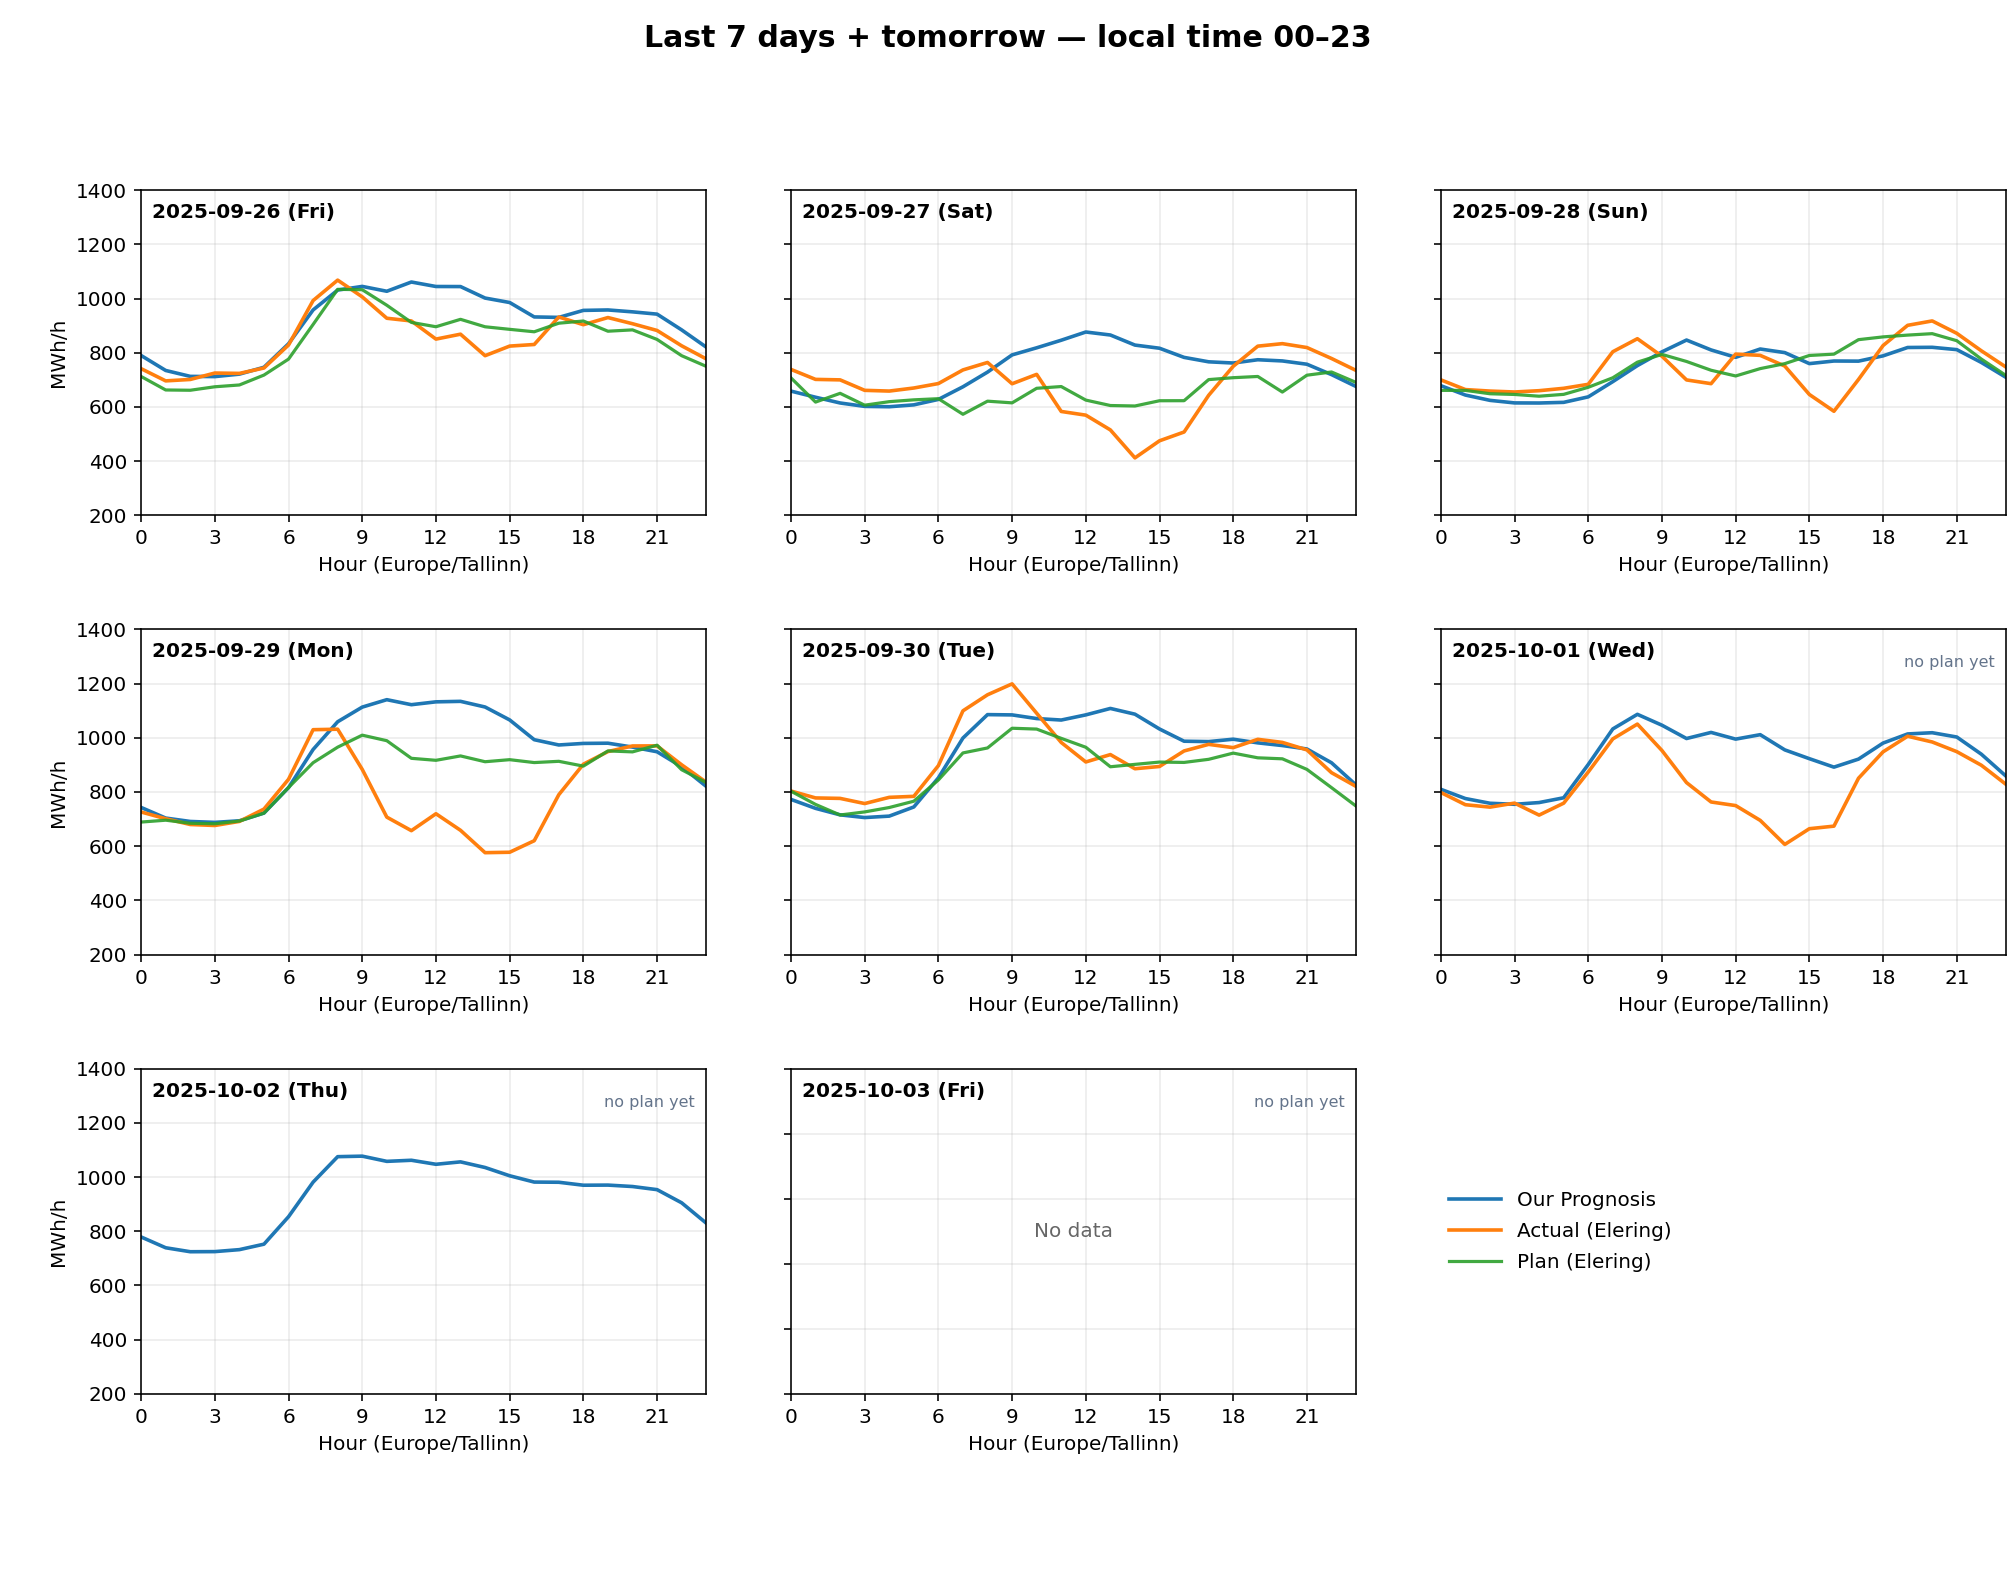

In [512]:
# === Static <details>-based HTML export (updated, with robust panel image fallback) ===
from datetime import datetime
from pathlib import Path
from IPython.display import HTML, display
import html as _html
import base64, mimetypes, pandas as pd, numpy as np
PLOTS_DIR = globals().get('PLOTS_DIR', Path.cwd())
DAY_FILTER = globals().get('DAY_FILTER', '')
REQUIRE_PLAN = globals().get('REQUIRE_PLAN', False)
panel_png = globals().get('panel_png', PLOTS_DIR / f"panel_local_{DAY_FILTER}{'_planreq' if REQUIRE_PLAN else ''}.png")
_raw_panel = globals().get('panel_uri', panel_png)
ape_block = globals().get('ape_section', globals().get('ape_html'))
metrics_block_src = globals().get('metrics_html') # ← use metrics_html built earlier

def to_data_uri(x):
    if not x:
        return None
    s = str(x)
    # If already a data URI, return as-is
    if s.startswith('data:'):
        return s
    p = Path(s)
    if p.is_file():
        mime = mimetypes.guess_type(p.name)[0] or 'image/png'
        return f"data:{mime};base64,{base64.b64encode(p.read_bytes()).decode('ascii')}"
    return None

def _find_latest_panel_png(base_dir: Path) -> Path | None:
    try:
        cands = sorted(base_dir.glob('panel_local_*.png'), key=lambda q: q.stat().st_mtime, reverse=True)
        return cands[0] if cands else None
    except Exception:
        return None

panel_data_uri = to_data_uri(_raw_panel)
fallback_used = None
if not panel_data_uri:
    # Try most recent panel image in PLOTS_DIR
    latest = _find_latest_panel_png(PLOTS_DIR)
    if latest:
        panel_data_uri = to_data_uri(latest)
        fallback_used = f"latest file: {latest.name}"
if not panel_data_uri:
    # Try saving current Matplotlib figure if available
    _fig = globals().get('fig')
    try:
        if _fig is not None:
            panel_png.parent.mkdir(parents=True, exist_ok=True)
            _fig.savefig(panel_png, dpi=140, bbox_inches='tight')
            panel_data_uri = to_data_uri(panel_png)
            fallback_used = f"saved fig → {panel_png.name}"
    except Exception:
        pass

now_ts = datetime.now().strftime('%Y-%m-%d %H:%M')

def section(title: str, body_html: str, open: bool = True) -> str:
    return f"""
    <details {'open' if open else ''} class='card'>
      <summary>{_html.escape(title)}</summary>
      <div class='body'>{body_html}</div>
    </details>
    """

# If metrics_html missing, warn
if not metrics_block_src:
    metrics_block_src = "<div style='color:#b91c1c'>Daily metrics HTML missing (metrics_html).</div>"

metrics_block = (
    "<div class='subtle'>Explanation: "
    "sum_abs_err_MWh = daily absolute error sum (Our vs Actual, only overlapping hours). "
    "day_avg_err_pct = daily relative average error = sum_abs_err_MWh / our_day_sum_MWh × 100. "
    "elering_sum_abs_err_MWh = Elering Plan vs Actual daily absolute error sum (snapshot/fallback). "
    "our_day_sum_MWh = our forecast 24h sum; actual_day_sum_MWh = actual 24h consumption sum. "
    "avg_abs_err_MWh = mean hourly absolute error (Our vs Actual) only on overlapping hours (N). "
    "max_abs_err_MWh = largest hourly absolute error (Our vs Actual). "
    "min_abs_err_MWh = smallest hourly absolute error (Our vs Actual). "
    "Units: MWh; % is percent."
    "</div>" + metrics_block_src
)

panel_img_html = (
    f"<img src='{panel_data_uri}' alt='panel' style='max-width:1200px;width:100%;border:1px solid #e5e7eb;border-radius:8px'/>"
    if panel_data_uri else f"<div style='color:#b91c1c'>Panel image data URI missing. Looked in: {PLOTS_DIR}</div>"
)

html_doc = f"""<!doctype html>
<html lang='en'>
<meta charset='utf-8'>
<title>Dashboard view (static)</title>
<meta name='viewport' content='width=device-width,initial-scale=1'/>
<style>
  body {{ font-family: system-ui, Arial, sans-serif; background:#f8fafc; margin:16px; color:#0f172a; }}
  h2 {{ margin:4px 0 12px; font-weight:600; }}
  .updated {{ font-size:12px; color:#475569; margin:-4px 0 14px; }}
  details.card {{ background:#ffffff; border:1px solid #e2e8f0; border-radius:10px; padding:8px 12px 12px; margin:14px 0; box-shadow:0 1px 2px rgba(0,0,0,0.05); }}
  details.card[open] {{ border-color:#94a3b8; }}
  details.card > summary {{ cursor:pointer; font-weight:600; font-size:15px; list-style:none; display:flex; align-items:center; gap:6px; }}
  details.card > summary::-webkit-details-marker {{ display:none; }}
  details.card > summary:before {{ content:'▶'; font-size:11px; color:#475569; transition:transform .15s ease; }}
  details.card[open] > summary:before {{ transform:rotate(90deg); }}
  details.card .body {{ margin-top:10px; }}
  /* Compact table layout + header wrapping (works with Styler output) */
  table {{ border-collapse:collapse; font-size:14px; table-layout:fixed; width:100%; }}
  th {{ background:#0f172a; color:#fff; text-align:center; padding:4px 8px;
      white-space:normal; overflow-wrap:anywhere; word-break:break-word; max-width:12ch; }}
  td {{ padding:4px 8px; font-variant-numeric: tabular-nums; text-align:right; }}
  .subtle {{ color:#475569; font-size:12px; margin:0 0 6px 2px; }}
</style>
<body>
  <h2>Dashboard</h2>
  <div class='updated'>Generated: {now_ts}</div>
  {section('Line panel — last 7 days + tomorrow', panel_img_html, open=True)}
  {section('Daily metrics', metrics_block, open=False)}
  {section('APE% (Our vs Actual) — hours × days — sparklines', ape_block or '<div style="color:#6b7280"><em>APE% block missing.</em></div>', open=False)}
</body>
</html>"""

out_html = PLOTS_DIR / 'dashboard_details.html'
out_html.write_text(html_doc, encoding='utf-8')
print("Saved static HTML:", out_html)
if fallback_used:
    print("Panel image fallback used:", fallback_used)

# Also copy to docs for GitHub Pages rendering
root = Path.cwd()
repo_root = root if (root / 'docs').exists() else root.parent
docs_dir = repo_root / 'docs'
docs_dir.mkdir(exist_ok=True)
docs_target = docs_dir / 'dashboard_details.html'
docs_target.write_text(html_doc, encoding='utf-8')
print("Copied for GitHub Pages:", docs_target)

try:
    display(HTML(html_doc))
except Exception:
    pass

In [513]:
# DIAG: Show paths and list forecast snapshot files
from pathlib import Path
SCRIPTS = globals().get('SCRIPTS', Path.cwd() if Path.cwd().name.lower() == 'scripts' else Path.cwd() / 'scripts')
QC_DIR = globals().get('QC_DIR', SCRIPTS / 'output' / 'qc')
print('CWD:', Path.cwd())
print('SCRIPTS:', SCRIPTS, '->', Path(SCRIPTS).resolve())
print('QC_DIR:', QC_DIR, '->', Path(QC_DIR).resolve())
_output = Path(SCRIPTS) / 'output'
print('OUTPUT:', _output, 'exists?', _output.exists())
print('Forecast files under OUTPUT:')
for p in sorted(_output.glob('forecast_consumption_hourly*next7*tallinn*.csv')):
    print(' -', p)

CWD: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts
SCRIPTS: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts -> C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts
QC_DIR: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc -> C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc
OUTPUT: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output exists? True
Forecast files under OUTPUT:
 - c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\forecast_consumption_hourly_next7_tallinn_20250918_20250924.csv
 - c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\ou

In [514]:
# Canonicalize SCRIPTS to absolute scripts folder and reset output dirs
from pathlib import Path
cwd = Path.cwd()
SCRIPTS = cwd if cwd.name.lower() == 'scripts' else ((cwd / 'scripts') if (cwd / 'scripts').exists() else cwd)
PLOTS_DIR = SCRIPTS / 'plots'
QC_DIR = SCRIPTS / 'output' / 'qc'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
QC_DIR.mkdir(parents=True, exist_ok=True)
print('SCRIPTS set to:', SCRIPTS.resolve())
print('PLOTS_DIR:', PLOTS_DIR.resolve())
print('QC_DIR:', QC_DIR.resolve())

SCRIPTS set to: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts
PLOTS_DIR: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots
QC_DIR: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\qc


In [515]:
# DIAG: check WP_DF coverage per day (local)
if 'WP_DF' in globals() and isinstance(WP_DF, pd.DataFrame) and not WP_DF.empty:
    _s = WP_DF.copy()
    _dt = pd.to_datetime(_s['datetime_hour'], errors='coerce', utc=True)
    _s['day_local'] = _dt.dt.tz_convert(TZ).dt.tz_localize(None).dt.floor('D')
    _s['hour_local'] = _dt.dt.tz_convert(TZ).dt.tz_localize(None).dt.hour
    _cov = (_s.groupby('day_local')['hour_local'].nunique().reset_index(name='plan_hours'))
    try:
        from IPython.display import display
        display(_cov.tail(10))
    except Exception:
        print(_cov.tail(10))
else:
    print('WP_DF missing or empty')


,day_local,plan_hours
0,2025-09-25,24
1,2025-09-26,24
2,2025-09-27,24
3,2025-09-28,24
4,2025-09-29,24
5,2025-09-30,24
6,2025-10-01,24
7,2025-10-02,24


In [516]:
# DIAG: Why plan not visible for yesterday?
import pandas as pd
try:
    tz = globals().get('TZ', 'Europe/Tallinn')
    today_loc = pd.Timestamp.now(tz=tz).tz_localize(None).floor('D')
    yday = today_loc - pd.Timedelta(days=1)
    print('Yesterday (local):', yday.date())
    # Check WP_DF plan availability
    if 'WP_DF' in globals() and isinstance(WP_DF, pd.DataFrame) and not WP_DF.empty:
        s = WP_DF.copy()
        dt = pd.to_datetime(s['datetime_hour'], errors='coerce')
        if getattr(getattr(dt, 'dt', None), 'tz', None) is None:
            dt = dt.dt.tz_localize('UTC')
        dt_loc = dt.dt.tz_convert(tz).dt.tz_localize(None)
        s['day_local'] = dt_loc.dt.floor('D')
        s['hour_local'] = dt_loc.dt.hour
        has_col = 'consumptionPlan' in s.columns
        nonnull = int(pd.to_numeric(s.loc[s['day_local']==yday, 'consumptionPlan'], errors='coerce').notna().sum()) if has_col else 0
        print('WP_DF consumptionPlan present?', has_col, ' non-null hours =', nonnull)
        print(s.loc[s['day_local']==yday, ['hour_local', 'consumptionPlan']].head(6) if has_col else 'consumptionPlan missing')
    else:
        print('WP_DF empty or missing')
    # Check provider output
    if 'plan_snapshot_for_local_day' in globals():
        ps_test = plan_snapshot_for_local_day(yday, tz=tz, min_hours=0)
        if ps_test is None or len(ps_test)==0:
            print('plan_snapshot_for_local_day returned None/empty for yesterday')
        else:
            print('plan_snapshot hours:', int(ps_test['hour_local'].nunique()))
            print(ps_test.head())
    else:
        print('plan_snapshot_for_local_day missing')
except Exception as e:
    print('DIAG error:', e)

Yesterday (local): 2025-10-01
WP_DF consumptionPlan present? True  non-null hours = 1
     hour_local  consumptionPlan
144           0          704.025
145           1              NaN
146           2              NaN
147           3              NaN
151           4              NaN
155           5              NaN
plan_snapshot hours: 1
   hour_local  plan_snapshot
0           0        704.025
